![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Computer Vision Concepts

You may recall *Practicum AI*'s heroine Amelia, the AI-savvy nutritionist. At the end of our [*Deep Learning Foundations* course](https://practicumai.org/courses/deep_learning/), Amelia was helping with a computer vision project. Her colleague, an entomologist named Kevin, had a dataset of images of bees and wasps and wanted to classify them.

**For this exercise, we have made a subsample of those data to make training easier.**

![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning/blob/main/images/bees_wasps_dataset-cover.png?raw=true)


## AI Pathway review for Bees vs Wasps

If you have taken our [*Getting Started with AI* course](https://practicumai.org/courses/getting_started/), you may remember this figure of the **AI Application Development Pathway**. Let's take a quick review of how we applied this pathway in the case of the Bees vs Wasps example.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we need to classify images as bees, wasps, other insects, or a non-insect. 
2. **Gather data:** The data for the example come from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp), a great repository of datasets, code, and models.
3. **Clean and prepare the data:** In the *Deep Learning Foundations* course, we assumed that this was done for us. One issue that we ran into was that of class imbalance. There are many more images in some classes than others, leading to a poor performing model. We won't address this yet, but will come back to it in notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb).
4. **Choose a model:** In the *Deep Learning Foundations* course, we presented the model with little detail. Now that we know more about Convolutional Neural Networks (CNNs) and some other tools at our disposal, we will explore the model in more detail.
   * As part of the iterative process of training models, one thing we noticed is that most of our models were **overfitting** — performing better on the training data than they did on the testing data. Essentially, the models memorized the training data but did not generalize well to new data that had not been seen. 
      * In this notebook, we will explore **dropout** as one mechanism to mitigate overfitting.
5. **Train the model:** In training the model we may have had a few issues. With so many hyperparameters to tune, it's easy to lose track of what combinations have been tried and how changes impacted model performance. 
   * In this notebook, we introduce you to [TensorBoard](https://www.tensorflow.org/tensorboard), one popular tool in a class of tools known as **experiment tracking** or **MLOps (Machine learning operations) tools**. These tools help track changes to hyperparameters, the training process, and the data. They allow comparison among runs and can even automate multiple runs for you. Learning to use MLOps tools will help you as you continue to learn more about AI workflows.
6. **Evaluate the model:** We will continue to assess how the model performs on the validation set and adjust the model and hyperparameters to attempt to produce a better model. However, as noted above in step 3, one issue we will continue to encounter is the class imbalance.    
   * This is a common issue with real data, and in notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb), we will explore some methods to handle this.
7. **Deploy the model:** We won"t get to this stage in this exercise, but hopefully, we will end up with a model that could be deployed and achieve relatively good accuracy at solving the problem.


## PyTorch and PyTorch Lightning

Since the introduction of the *Practicum AI* program, the AI landscape has shifted significantly (no real surprise there!!). While [TensorFlow](https://www.tensorflow.org/) seemed like a good choice at the time, and it can certainly be easier to get started with, the reality is that [Pytorch](https://pytorch.org/) has gained much more popularity. At this point, the *Practicum AI* team has made the decision to transition our code to use Pytorch. 

### PyTorch Lightning 

<img src='images/Lightning_logo.svg' alt="PyTorch Lightning logo" width="20%" align="right">

[PyTorch Lightning](https://lightning.ai/) is an open-source framework built on top of PyTorch that makes training deep learning models more straightforward. It abstracts many common tasks like managing training loops, logging, checkpointing, and handling hardware setups, allowing you to focus on the core aspects of your model and experimentation. 

Rather than writing repetitive code, you define key methods—such as `training_step` and `validation_step`—to describe the model's behavior while the Lightning trainer automates optimization details, synchronization, and even distributed training. This separation between scientific code and engineering routines leads to cleaner, more maintainable projects that are easier to scale.

Additionally, PyTorch Lightning integrates smoothly with popular tools such as [TensorBoard](https://www.tensorflow.org/tensorboard), which simplifies tracking experiment metrics and visualizing performance. Overall, Lightning streamlines the training workflow, boosts reproducibility, and helps both beginners and seasoned researchers concentrate on innovation, not boilerplate coding.

This course will make use of Lightning to simplify training.

Over time, the Beginner Series of courses will also be updated to have Pytorch versions.

## Outline of this notebook

This notebook covers a fair bit of ground. To orient you, here's an outline of the topics covered. Note that you can also open the notebook outline to see section headers.

1. Run through loading the data and exploring it a bit ([sections 1](#1.-Import-the-libraries-we-will-use) through 5).
1. Set initial hyperparameters, train a CNN model, and evaluate the performance ([sections 6](#6.-Make-our-model) through 8).
1. Explore Tensorboard as a tool to gain more insight into model performance ([section 9](#9.-View-training-metrics-in-TensorBoard)).
1. Spend some time tuning hyperparameters and evaluating the impact on model performance ([section 10](#10.-Explore-hyperparameters!))
1. Summarize the results obtaiend so far ([section 11](#11.-Summary-so-far))
1. Explore what a convolutional kernel is in more detail, visualizing kernels and convolved images ([section 12](#12.-A-look-inside-CNNs))
1. Add dropout to our model ([section 13](#13.-Dropout)) and discuss the padding and stride hyperparameters ([section 14](#14.-Padding-and-stride-for-convolutional-layers))
1. Conclude with a summary of the results and motivate the next notebook ([section 15](#15.-Conclusion))

## 1. Import the libraries we will use

In [1]:
import torch
import torch.nn.functional as F
import os

from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

# Many functions are moved to helpers_01.py to keep this file clean.
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)

# Check if torchmetrics is available
try:
    import torchmetrics
    print("torchmetrics is available")
except ImportError:
    print("torchmetrics not found. If you get errors, install with: pip install torchmetrics")

[rank: 0] Seed set to 42


torchmetrics is available


## 2. Check PyTorch installation

In [2]:
# Print Pytorch versions and check for GPU
print(f'Pytorch version: {torch.__version__}')
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'  Available GPU: {torch.cuda.get_device_name()}')
else:
    print('  No GPU available, will use CPU')

Pytorch version: 2.7.1+cu128
  Should be "True" if Pytorch was built for GPU: True
  Available GPU: NVIDIA B200
  Available GPU: NVIDIA B200


## 3. Getting the data

For details about the dataset and the code used to get the data you can look at the [helpers_01.py file](helpers_01.py). 

If you need to download the data, it is [hosted for public download from HiPerGator as a `tar.gz` file](https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz). If you need to manually extract the data, you can add a cell and run: `helpers_01.extract_file("bee_vs_wasp.tar.gz", "data")`


In [3]:
# Check for the data.
# This will look for the data files required for this notebook in some common locations.
#   * If it can't find the data, it will ask if you know where it is. 
#   * If you do, answer yes and provide the path to the data 
#       (up to and including the `bee_vs_wasp` folder name). 
#   * If not, it will ask if you want to download it. 
#      * If you answer yes, it will download the data and
#        extract it into your data folder.

data_path = helpers_01.manage_data(folder_name='bee_vs_wasp_reduced',)

Found data at data/bee_vs_wasp_reduced.


## 4. Setting the number of workers

One of the really great things about Pytorch Lightning is that it can efficiently use multiple CPUs (or cores) to do things like load data. This can be important in keeping the GPU fed with data rather that sitting idle waiting for data.

The cell below will set the number of workers, using a manually set number (change `None` in the first line of code to an integer), a number from the Slurm scheduler used on many computer clusters, or the number of CPU cores on the computer. 

In [4]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Using 4 workers for data loading.


## 5. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.

The `helpers_01.load_display_data()` function takes: 
* A path to the data: set from above.
* The batch size: set as 32 below, but a good hyperparameter to tune.
* Target shape for images: set as 80x80 color images below, another possible hyperparameter.
* Whether or not to show sample images.
* The train/validation split
* The number of workers

The function returns training and validation datasets. To help highlight the class imbalance issue, the function has been updated to report the numbers of images and percent of the total in each class.

******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
            bee         249         24.7%
   other_insect         254         25.2%
 other_noinsect         252         25.0%
           wasp         252         25.0%
--------------------------------------------
The classes in your dataset are: ['bee', 'other_insect', 'other_noinsect', 'wasp']


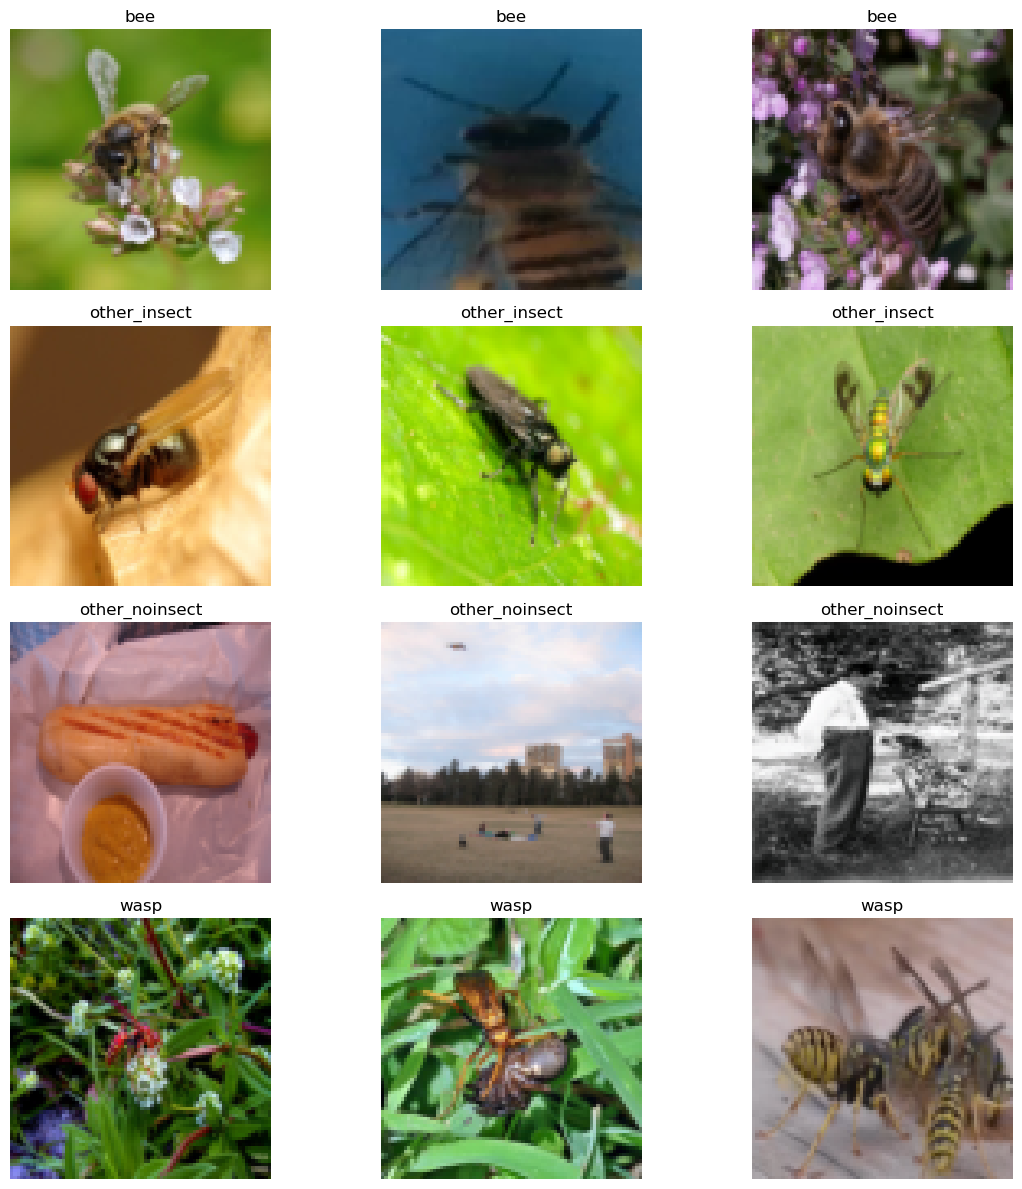

In [5]:
# Use the Lightning DataModule from helpers_01
data_module = helpers_01.load_display_data(
    data_path, 
    batch_size=32, 
    shape=(80, 80, 3), 
    show_pictures=True,
    train_split=0.8,  # 80% train, 20% validation
    num_workers=num_workers     # Number of workers for data loading
)

## 6. Train the Model

Using PyTorch Lightning's standard patterns, we create a LightningModule that defines:

- **Model architecture** in `__init__` and `forward`
- **Training logic** in `training_step` 
- **Validation logic** in `validation_step`
- **Optimizer configuration** in `configure_optimizers`
- **Built-in metrics** using Lightning's torchmetrics integration

The training process is handled by Lightning's `Trainer` which provides:
- Automatic GPU/CPU handling
- Built-in logging to TensorBoard
- Model checkpointing and early stopping
- Progress bars and model summaries

In [6]:
# Train the model using standard PyTorch Lightning approach
model, trainer = helpers_01.train_model(
    data_module=data_module,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator='auto',  # Lightning will choose GPU if available
    devices='auto',      # Lightning will choose optimal device count
    input_shape=(3, 80, 80)  # Match the shape used in data loading
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/mod

/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█| 26/26 [00:08<00:00,  3.20it/s, v_num=9, train_loss_step=1.260, val_loss=1.140, va

Metric val_loss improved. New best score: 1.143


Epoch 1: 100%|█| 26/26 [00:02<00:00, 12.74it/s, v_num=9, train_loss_step=1.480, val_loss=1.060, va

Metric val_loss improved by 0.085 >= min_delta = 0.001. New best score: 1.058


Epoch 2: 100%|█| 26/26 [00:01<00:00, 17.06it/s, v_num=9, train_loss_step=0.792, val_loss=0.996, va

Metric val_loss improved by 0.061 >= min_delta = 0.001. New best score: 0.996


Epoch 3: 100%|█| 26/26 [00:01<00:00, 22.84it/s, v_num=9, train_loss_step=0.532, val_loss=0.918, va

Metric val_loss improved by 0.078 >= min_delta = 0.001. New best score: 0.918


Epoch 4: 100%|█| 26/26 [00:00<00:00, 26.70it/s, v_num=9, train_loss_step=0.618, val_loss=0.869, va

Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 0.869


Epoch 9: 100%|█| 26/26 [00:01<00:00, 21.82it/s, v_num=9, train_loss_step=0.152, val_loss=0.913, va

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.869. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=10` reached.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 26/26 [00:01<00:00, 13.57it/s, v_num=9, train_loss_step=0.152, val_loss=0.913, va



## 7. Evaluate the model

The `test_model` function will now provide comprehensive evaluation including:
- Test accuracy and loss metrics
- Training and validation loss curves over epochs
- Training and validation accuracy curves over epochs  
- Confusion matrix showing prediction accuracy per class
- Per-class precision, recall, and F1 scores

These visualizations help us understand:
- **Loss curves**: Whether the model is overfitting (validation loss increases while training loss decreases)
- **Accuracy curves**: How well the model generalizes to unseen data
- **Confusion matrix**: Which classes the model confuses with each other
- **Per-class metrics**: How well the model performs on each individual class

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|█████████████████████████████████████████| 7/7 [00:00<00:00, 20.72it/s]
───────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6732673048973083
        test_loss           0.8688075542449951
───────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6732673048973083
        test_loss           0.8688075542449951
───────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: [

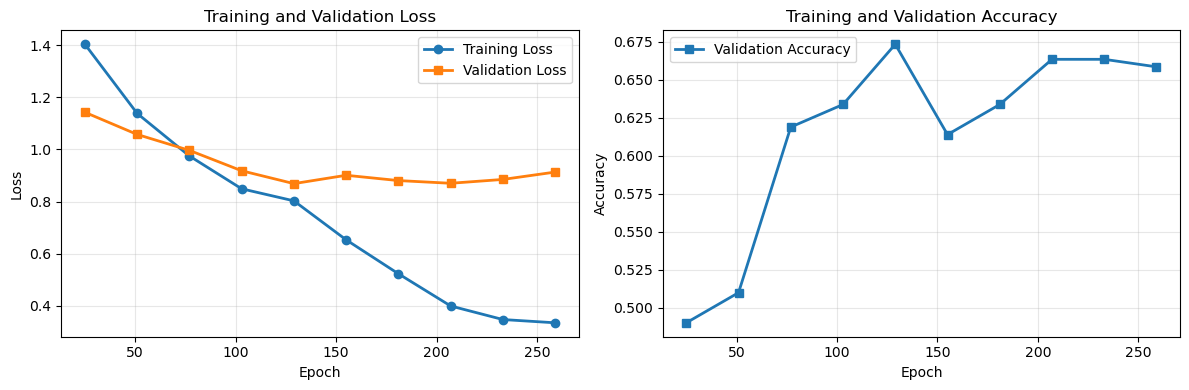

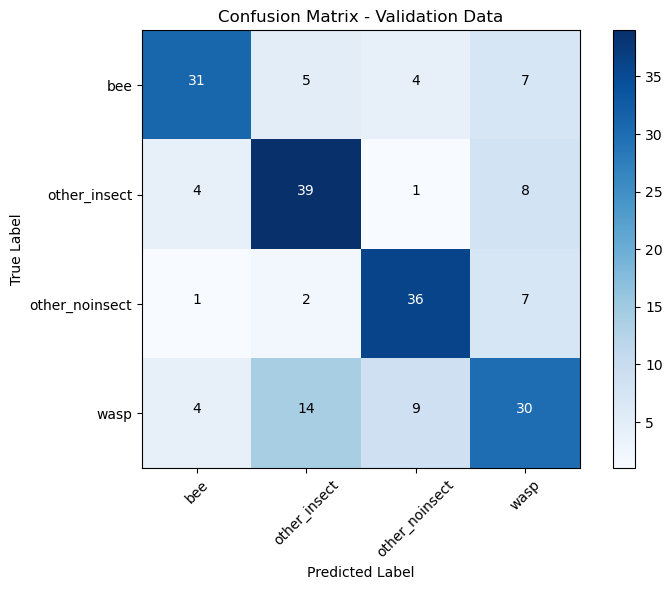


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.775, Recall=0.660, F1=0.713
   other_insect: Precision=0.650, Recall=0.750, F1=0.696
 other_noinsect: Precision=0.720, Recall=0.783, F1=0.750
           wasp: Precision=0.577, Recall=0.526, F1=0.550

Overall Test Results:
test_loss: 0.8688
test_acc: 0.6733


In [ ]:
# Test the model and display comprehensive evaluation plots

test_results = helpers_01.test_model(data_module, model, trainer)


## 9. View training metrics in TensorBoard

Now that we've run one training cycle, we can open TensorBoard and have a look at the visualizations it provides to evaluate training performance.

The detailed instructions for different platforms are in the course content. In general, we use the `tensorboard --logdir ./logs` command to start TensorBoard and then connect in a Web browser. Here's a screenshot of what that might look like:

![Screenshot of the TensorBoard web page](images/tensorboard_screenshot.png)

In [8]:
# View TensorBoard logs
%load_ext tensorboard
%tensorboard --logdir lightning_logs/